**Import Libraries and Load Data**

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, confusion_matrix

In [18]:
try:
    data = pd.read_csv('/content/drive/MyDrive/creditcard.csv')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: File not found. Please check the path.")

Dataset loaded successfully!


**Data Preparation**

In [19]:
# Define X (Features) and Y (Target)
columns = [c for c in data.columns if c not in ["Class"]]
X = data[columns]
Y = data["Class"]

# Split data: 80% Train, 20% Test
# We use random_state=42 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Calculate Outlier Fraction (needed for Anomaly Detection models)
fraud_cases = len(Y[Y == 1])
valid_cases = len(Y[Y == 0])
outlier_fraction = fraud_cases / valid_cases

print(f"Test Set Shape: {X_test.shape}")
print(f"Fraud Ratio (Outlier Fraction): {outlier_fraction:.5f}")

Test Set Shape: (56962, 30)
Fraud Ratio (Outlier Fraction): 0.00173


**Model 1 - Isolation Forest (Unsupervised)**

In [20]:
print("Running Isolation Forest...")

# Initialize Model
# We fit the model on X_test directly to find anomalies in the test set
iso_forest = IsolationForest(n_estimators=100,
                             max_samples=len(X_test),
                             contamination=outlier_fraction,
                             random_state=42,
                             n_jobs=-1)

iso_forest.fit(X_test)
y_pred_iso = iso_forest.predict(X_test)

# Map predictions: 1 -> 0 (Normal), -1 -> 1 (Fraud)
y_pred_iso[y_pred_iso == 1] = 0
y_pred_iso[y_pred_iso == -1] = 1

print("Isolation Forest Completed.")

Running Isolation Forest...
Isolation Forest Completed.


**Model 2 - Local Outlier Factor (Unsupervised)**

In [22]:
print("Running Local Outlier Factor (LOF)...")

# Taking a smaller sample from X_test to speed up LOF (Computationally expensive)
# Using only 10% of the test set for LOF
X_test_lof = X_test.iloc[:5000]
y_test_lof = y_test.iloc[:5000]

lof = LocalOutlierFactor(n_neighbors=20,
                         algorithm='auto',
                         contamination=outlier_fraction)

# Fit and Predict
y_pred_lof = lof.fit_predict(X_test_lof)

# Map predictions: 1 -> 0 (Normal), -1 -> 1 (Fraud)
y_pred_lof[y_pred_lof == 1] = 0
y_pred_lof[y_pred_lof == -1] = 1

print("LOF Completed.")

Running Local Outlier Factor (LOF)...
LOF Completed.


**Model 3 - Random Forest (Supervised)**

In [23]:
print("Training Random Forest Classifier...")

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Train on Training Data
rf_model.fit(X_train, y_train)

# Predict on Test Data
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Completed.")

Training Random Forest Classifier...
Random Forest Completed.


**Model 4 - LIGHTGBM (Supervised - Gradient Boosting)**

In [26]:
from lightgbm import LGBMClassifier

print("Training LightGBM Classifier (with is_unbalance=True)...")

# is_unbalance=True: Modele verinin dengesiz olduğunu ve azınlık sınıfına (Fraud)
# öncelik vermesi gerektiğini söyleriz.
lgbm_model = LGBMClassifier(n_estimators=100,
                            is_unbalance=True,  # <-- SİHİRLİ DOKUNUŞ BURADA!
                            random_state=42,
                            n_jobs=-1,
                            verbose=-1)

# Eğit
lgbm_model.fit(X_train, y_train)

# Test Et
y_pred_lgbm = lgbm_model.predict(X_test)

print("LightGBM Tuned Completed.")

Training LightGBM Classifier (with is_unbalance=True)...
LightGBM Tuned Completed.


**Model 5 - SMOTE + Random Forest**

In [32]:
from imblearn.over_sampling import SMOTE

print("Applying SMOTE to generate synthetic fraud data...")

# 1. Initialize SMOTE
smote = SMOTE(random_state=42)

# 2. Apply SMOTE to Training Data ONLY
# CRITICAL: Never apply SMOTE to Test data, it causes data leakage!
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Display class distribution before and after
print(f"Original Training Shape: {y_train.value_counts()}")
print(f"Resampled (SMOTE) Training Shape: {y_train_smote.value_counts()}")
# Now Fraud (1) and Normal (0) counts should be equal in the training set

print("\nTraining Random Forest on SMOTE data...")
# We use a standard Random Forest (no need for class_weight adjustments here)
rf_smote = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Fit on the SMOTE-augmented training data
rf_smote.fit(X_train_smote, y_train_smote)

# Predict on the original Test data
y_pred_smote = rf_smote.predict(X_test)

print("SMOTE + Random Forest Completed.")

Applying SMOTE to generate synthetic fraud data...
Original Training Shape: Class
0    227451
1       394
Name: count, dtype: int64
Resampled (SMOTE) Training Shape: Class
0    227451
1    227451
Name: count, dtype: int64

Training Random Forest on SMOTE data...
SMOTE + Random Forest Completed.


**GRAND BENCHMARK - COMPARISON & VISUALIZATION**

/tmp/ipython-input-2955293916.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x='Model', y='Recall (Fraud Capture)', data=df_results, palette='viridis')
/tmp/ipython-input-2955293916.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=df_results, palette='magma')


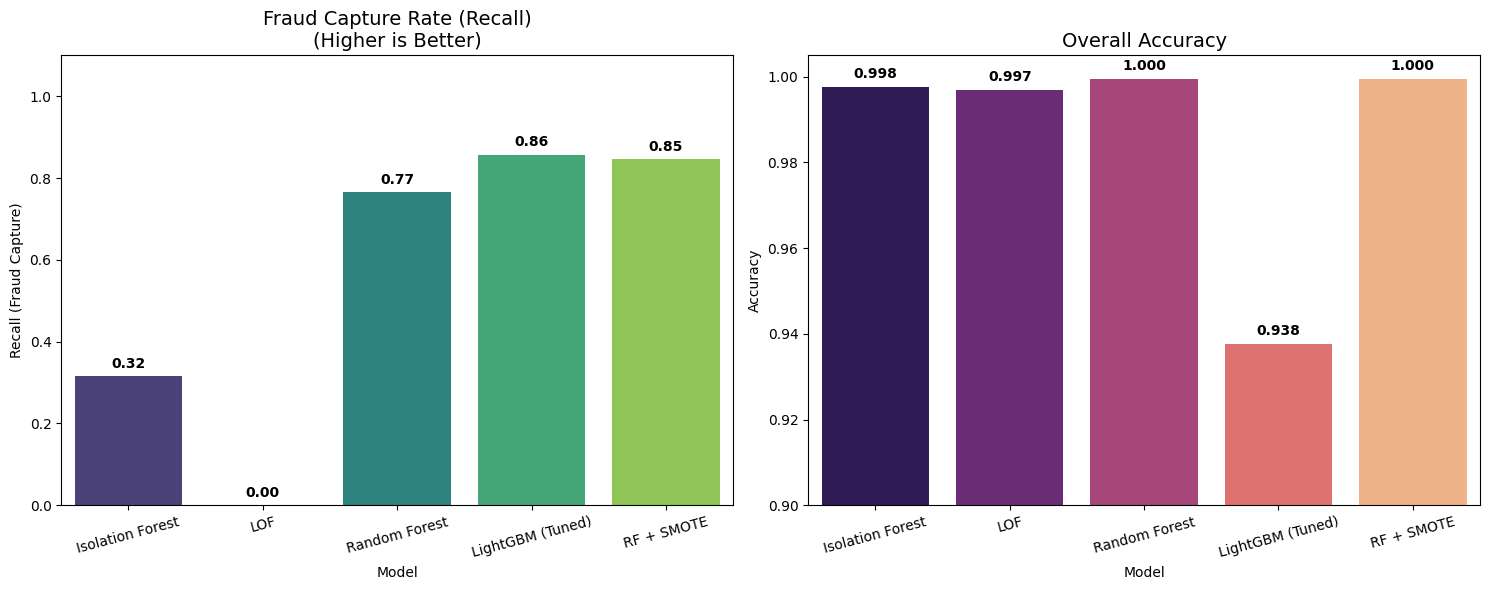


--- ULTIMATE BENCHMARK TABLE ---
              Model  Accuracy  Recall (Fraud Capture)  Precision
0  Isolation Forest  0.997630                0.316327   0.313131
1               LOF  0.997000                0.000000   0.000000
2     Random Forest  0.999561                0.765306   0.974026
3  LightGBM (Tuned)  0.937660                0.857143   0.023198
4        RF + SMOTE  0.999526                0.846939   0.873684


In [33]:
results = {
    'Model': ['Isolation Forest', 'LOF', 'Random Forest', 'LightGBM (Tuned)', 'RF + SMOTE'],

    'Accuracy': [
        accuracy_score(y_test, y_pred_iso),
        accuracy_score(y_test_lof, y_pred_lof),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_lgbm),
        accuracy_score(y_test, y_pred_smote) # New Contender
    ],

    'Recall (Fraud Capture)': [
        recall_score(y_test, y_pred_iso),
        recall_score(y_test_lof, y_pred_lof),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_lgbm),
        recall_score(y_test, y_pred_smote) # New Contender
    ],

    'Precision': [
        precision_score(y_test, y_pred_iso),
        precision_score(y_test_lof, y_pred_lof),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_lgbm),
        precision_score(y_test, y_pred_smote) # New Contender
    ]
}

df_results = pd.DataFrame(results)

# --- VISUALIZATION ---
plt.figure(figsize=(15, 6))

# Plot 1: Recall
plt.subplot(1, 2, 1)
ax1 = sns.barplot(x='Model', y='Recall (Fraud Capture)', data=df_results, palette='viridis')
plt.title('Fraud Capture Rate (Recall)\n(Higher is Better)', fontsize=14)
plt.ylim(0, 1.1)
plt.xticks(rotation=15)
for index, row in df_results.iterrows():
    ax1.text(index, row['Recall (Fraud Capture)'] + 0.02,
             f"{row['Recall (Fraud Capture)']:.2f}", ha='center', fontweight='bold')

# Plot 2: Accuracy
plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='Accuracy', data=df_results, palette='magma')
plt.title('Overall Accuracy', fontsize=14)
plt.ylim(0.90, 1.005)
plt.xticks(rotation=15)
for index, row in df_results.iterrows():
    plt.text(index, row['Accuracy'] + 0.002,
             f"{row['Accuracy']:.3f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n--- ULTIMATE BENCHMARK TABLE ---")
print(df_results)